# Data Analysis

## Load Data

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option("display.max_columns", None)


account = pd.read_csv('data/account.csv', dtype={'date':object})
card_dev = pd.read_csv('data/card_dev.csv', dtype={'issued':object})
client = pd.read_csv('data/client.csv', dtype={'birth_number':object})
disposition = pd.read_csv('data/disp.csv')
district = pd.read_csv('data/district.csv')
loan_dev = pd.read_csv('data/loan_dev.csv', dtype={'date':object})
trans_dev = pd.read_csv('data/trans_dev.csv', 
                        dtype={'account_id':int, 'date':object, 'type':object, 'operation':object, 'amount':float, 'balance':float, 'k_symbol':object, 'bank':object, 'account':float})

data = pd.read_csv('data_processed/data.csv')

## General Attribute Analysis

The data is organized in data tables so each table has an ammount of attributes that can be analised to better understand their significance.

In [19]:
print(f'''
account     shape: {account.shape}
client      shape: {client.shape}
disposition shape: {disposition.shape}
district    shape: {district.shape}
card        shape: {card_dev.shape}
loan        shape: {loan_dev.shape}
trans       shape: {trans_dev.shape}

data        shape: {data.shape}
''')


account     shape: (4500, 4)
client      shape: (5369, 3)
disposition shape: (5369, 4)
district    shape: (77, 16)
card        shape: (177, 4)
loan        shape: (328, 7)
trans       shape: (396685, 10)

data        shape: (328, 36)



In [20]:
def get_correlation(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    plt.subplots(figsize=(30,24))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,square=True, linewidths=.1, cbar_kws={"shrink": .5}, annot = True)

    y_lim = ax.get_ylim();
    ax.set_ylim(np.ceil(y_lim[0]), np.floor(y_lim[1]))
    
    plt.show()

## Account Analysis

In [21]:
display(account.head())
print(account.info())
display(account.describe())


,account_id,district_id,frequency,date
0,576,55,monthly issuance,930101
1,3818,74,monthly issuance,930101
2,704,55,monthly issuance,930101
3,2378,16,monthly issuance,930101
4,2632,24,monthly issuance,930102


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   account_id   4500 non-null   int64 
 1   district_id  4500 non-null   int64 
 2   frequency    4500 non-null   object
 3   date         4500 non-null   object
dtypes: int64(2), object(2)
memory usage: 140.8+ KB
None


,account_id,district_id
count,4500.000000,4500.000000
mean,2786.067556,37.310444
std,2313.811984,25.177217
min,1.000000,1.000000
25%,1182.750000,13.000000
50%,2368.000000,38.000000
75%,3552.250000,60.000000
max,11382.000000,77.000000


monthly issuance              4167
weekly issuance                240
issuance after transaction      93
Name: frequency, dtype: int64

<BarContainer object of 3 artists>

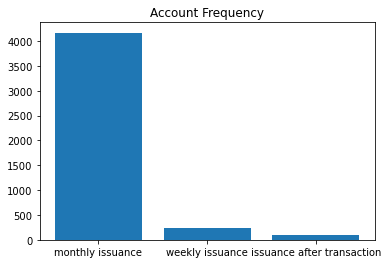

In [22]:
account_frequency = account["frequency"].value_counts()
display(account_frequency)

plt.title("Account Frequency")
plt.bar(list(account_frequency.keys()), list(account_frequency))

### Features conclusions

## Card Analysis

In [23]:
display(card_dev.head())
display(card_dev.info())
display(card_dev.describe())


,card_id,disp_id,type,issued
0,1005,9285,classic,931107
1,104,588,classic,940119
2,747,4915,classic,940205
3,70,439,classic,940208
4,577,3687,classic,940215


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   card_id  177 non-null    int64 
 1   disp_id  177 non-null    int64 
 2   type     177 non-null    object
 3   issued   177 non-null    object
dtypes: int64(2), object(2)
memory usage: 5.7+ KB


None

,card_id,disp_id
count,177.000000,177.000000
mean,433.576271,3031.723164
std,290.507562,2632.338944
min,3.000000,41.000000
25%,183.000000,1080.000000
50%,397.000000,2513.000000
75%,661.000000,4270.000000
max,1247.000000,13660.000000


classic    127
junior      41
gold         9
Name: type, dtype: int64

<BarContainer object of 3 artists>

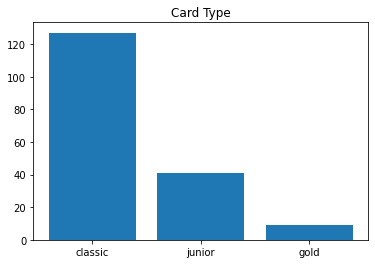

In [24]:
card_type = card_dev["type"].value_counts()
display(card_type)

plt.figure()
plt.title("Card Type")
plt.bar(list(card_type.keys()), list(card_type))

### Features conclusions

## Client Analysis

In [25]:
display(client.head())
display(client.info())
display(client.describe())


,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   client_id     5369 non-null   int64 
 1   birth_number  5369 non-null   object
 2   district_id   5369 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 126.0+ KB


None

,client_id,district_id
count,5369.000000,5369.000000
mean,3359.011920,37.310114
std,2832.911984,25.043690
min,1.000000,1.000000
25%,1418.000000,14.000000
50%,2839.000000,38.000000
75%,4257.000000,60.000000
max,13998.000000,77.000000


### Features conclusions

## Disposition Analysis

In [26]:
display(disposition.head())
display(disposition.info())
display(disposition.describe())


,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   disp_id     5369 non-null   int64 
 1   client_id   5369 non-null   int64 
 2   account_id  5369 non-null   int64 
 3   type        5369 non-null   object
dtypes: int64(3), object(1)
memory usage: 167.9+ KB


None

,disp_id,client_id,account_id
count,5369.000000,5369.000000,5369.000000
mean,3337.097970,3359.011920,2767.496927
std,2770.418826,2832.911984,2307.843630
min,1.000000,1.000000,1.000000
25%,1418.000000,1418.000000,1178.000000
50%,2839.000000,2839.000000,2349.000000
75%,4257.000000,4257.000000,3526.000000
max,13690.000000,13998.000000,11382.000000


OWNER        4500
DISPONENT     869
Name: type, dtype: int64

<BarContainer object of 2 artists>

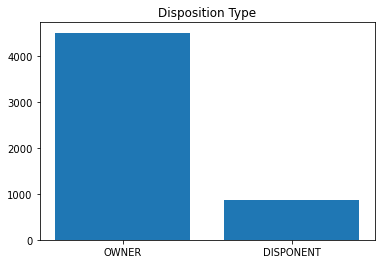

In [27]:
disp_type = disposition["type"].value_counts()
display(disp_type)

plt.figure()
plt.title("Disposition Type")
plt.bar(list(disp_type.keys()), list(disp_type))

### Features conclusions

## District Analysis

In [28]:
display(district.head())
display(district.info())
display(district.describe())


,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   code                                              77 non-null     int64  
 1   name                                              77 non-null     object 
 2   region                                            77 non-null     object 
 3   no. of inhabitants                                77 non-null     int64  
 4   no. of municipalities with inhabitants < 499      77 non-null     int64  
 5   no. of municipalities with inhabitants 500-1999   77 non-null     int64  
 6   no. of municipalities with inhabitants 2000-9999  77 non-null     int64  
 7   no. of municipalities with inhabitants >10000     77 non-null     int64  
 8   no. of cities                                     77 non-null     int64  
 9   ratio of urban inhabita

None

,code,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '96
count,77.000000,7.700000e+01,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,39.000000,1.338849e+05,48.623377,24.324675,6.272727,1.727273,6.259740,63.035065,9031.675325,3.787013,116.129870,5030.831169
std,22.371857,1.369135e+05,32.741829,12.780991,4.015222,1.008338,2.435497,16.221727,790.202347,1.908480,16.608773,11270.796786
min,1.000000,4.282100e+04,0.000000,0.000000,0.000000,0.000000,1.000000,33.900000,8110.000000,0.430000,81.000000,888.000000
25%,20.000000,8.585200e+04,22.000000,16.000000,4.000000,1.000000,5.000000,51.900000,8512.000000,2.310000,105.000000,2122.000000
50%,39.000000,1.088710e+05,49.000000,25.000000,6.000000,2.000000,6.000000,59.800000,8814.000000,3.600000,113.000000,3040.000000
75%,58.000000,1.390120e+05,71.000000,32.000000,8.000000,2.000000,8.000000,73.500000,9317.000000,4.790000,126.000000,4595.000000
max,77.000000,1.204953e+06,151.000000,70.000000,20.000000,5.000000,11.000000,100.000000,12541.000000,9.400000,167.000000,99107.000000


Hl.m. Praha      1
Svitavy          1
Hodonin          1
Breclav          1
Brno - venkov    1
                ..
Plzen - mesto    1
Klatovy          1
Karlovy Vary     1
Cheb             1
Vsetin           1
Name: name, Length: 77, dtype: int64

south Moravia      14
central Bohemia    12
east Bohemia       11
north Moravia      11
west Bohemia       10
north Bohemia      10
south Bohemia       8
Prague              1
Name: region, dtype: int64

<BarContainer object of 8 artists>

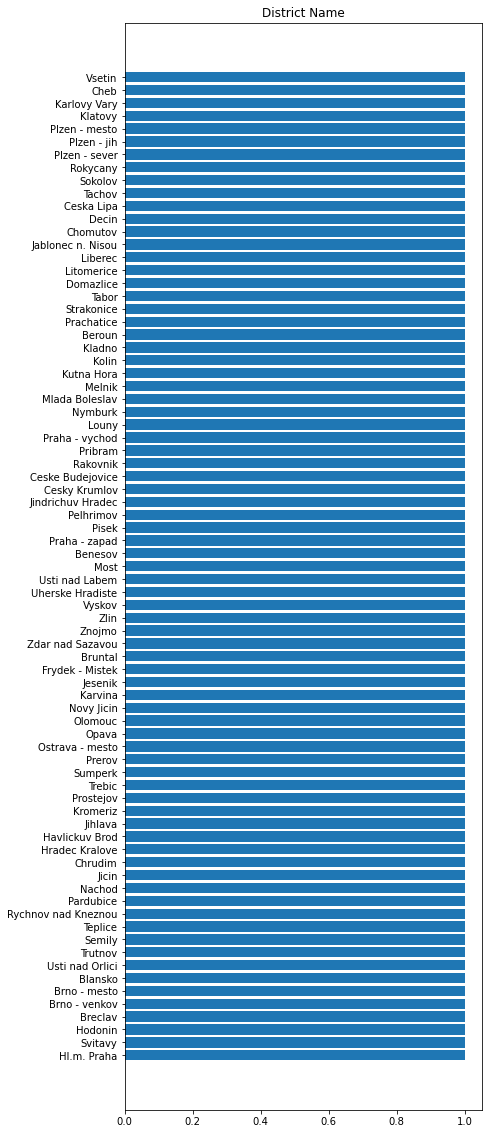

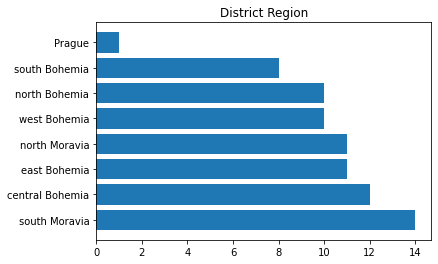

In [29]:
district_name = district["name"].value_counts()
display(district_name)
plt.figure(figsize=[6.4, 20])
plt.title("District Name")
plt.barh(list(district_name.keys()), list(district_name))

district_region = district["region"].value_counts()
display(district_region)
plt.figure()
plt.title("District Region")
plt.barh(list(district_region.keys()), list(district_region))

### Features conclusions

- District Name has no significance, it could be an id


## Transaction Analysis

In [30]:
display(trans_dev.head())
display(trans_dev.info())
display(trans_dev.describe())

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,NaN,NaN,NaN
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,NaN,IJ,80269753.0
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,NaN,NaN,NaN
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,NaN,NaN,NaN
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396685 entries, 0 to 396684
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   trans_id    396685 non-null  int64  
 1   account_id  396685 non-null  int64  
 2   date        396685 non-null  object 
 3   type        396685 non-null  object 
 4   operation   325924 non-null  object 
 5   amount      396685 non-null  float64
 6   balance     396685 non-null  float64
 7   k_symbol    211441 non-null  object 
 8   bank        97242 non-null   object 
 9   account     102229 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 30.3+ MB


None

,trans_id,account_id,amount,balance,account
count,3.966850e+05,396685.000000,396685.000000,396685.000000,1.022290e+05
mean,1.239338e+06,2508.434796,5677.552980,35804.792507,4.664229e+07
std,1.213288e+06,2020.928889,9190.364137,19692.148243,3.002136e+07
min,1.000000e+00,1.000000,0.000000,-13588.700000,0.000000e+00
25%,3.918330e+05,1092.000000,127.500000,22424.300000,1.990018e+07
50%,7.882580e+05,2220.000000,1952.000000,30959.600000,4.673618e+07
75%,1.273700e+06,3357.000000,6500.000000,44661.000000,7.232217e+07
max,3.682934e+06,11382.000000,86400.000000,193909.900000,9.998564e+07


withdrawal            232093
credit                159468
withdrawal in cash      5124
Name: type, dtype: int64

withdrawal in cash              165270
remittance to another bank       70737
credit in cash                   62202
collection from another bank     26505
credit card withdrawal            1210
Name: operation, dtype: int64

interest credited                        70761
payment for statement                    58377
household                                42839
                                         19065
old-age pension                          13502
insurrance payment                        6592
sanction interest if negative balance      305
Name: k_symbol, dtype: int64

ST    8114
GH    7886
EF    7878
AB    7666
UV    7618
OP    7595
IJ    7536
YZ    7471
QR    7413
KL    7397
WX    7033
CD    7009
MN    6626
Name: bank, dtype: int64

<BarContainer object of 13 artists>

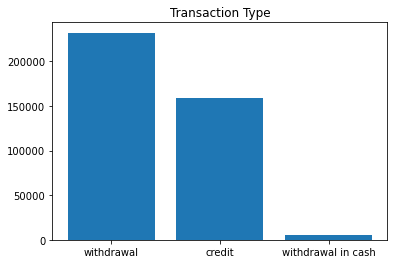

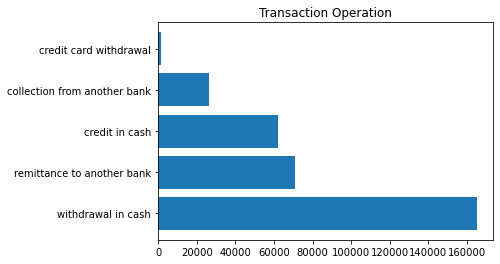

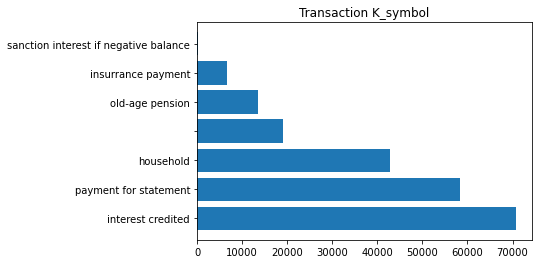

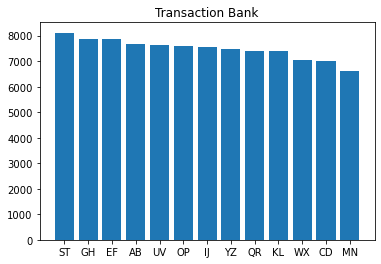

In [31]:
trans_type = trans_dev["type"].value_counts()
display(trans_type)
plt.figure()
plt.title("Transaction Type")
plt.bar(list(trans_type.keys()), list(trans_type))

trans_operation = trans_dev["operation"].value_counts()
display(trans_operation)
plt.figure()
plt.title("Transaction Operation")
plt.barh(list(trans_operation.keys()), list(trans_operation))

trans_k_symbol = trans_dev["k_symbol"].value_counts()
display(trans_k_symbol)
plt.figure()
plt.title("Transaction K_symbol")
plt.barh(list(trans_k_symbol.keys()), list(trans_k_symbol))

trans_bank = trans_dev["bank"].value_counts()
display(trans_bank)
plt.figure()
plt.title("Transaction Bank")
plt.bar(list(trans_bank.keys()), list(trans_bank))

In [32]:
# Describe mean balance for each account

balance_mean_by_account = trans_dev.groupby('account_id')['balance'].mean()
display(balance_mean_by_account.describe())


count     3370.000000
mean     32661.207285
std      15413.094042
min        200.000000
25%      21703.451760
50%      30676.254970
75%      42946.517635
max      82499.700000
Name: balance, dtype: float64

In [33]:
# Describe mean transaction amount for each transaction type

amount_mean_by_transaction_type = trans_dev.groupby('type')['amount'].mean()
display(amount_mean_by_transaction_type)

amount_mean_by_transaction_operation = trans_dev.groupby('operation')['amount'].mean()
display(amount_mean_by_transaction_operation)

type
credit                 7434.713441
withdrawal             4318.954543
withdrawal in cash    12529.684621
Name: amount, dtype: float64

operation
collection from another bank    10330.615544
credit card withdrawal           2176.280992
credit in cash                  14497.925694
remittance to another bank       3048.708498
withdrawal in cash               5132.882118
Name: amount, dtype: float64

### Features conclusions

- Transaction k_symbol has empty values besides NaN

## Loan Analysis

In [34]:
display(loan_dev.head())
display(loan_dev.info())
display(loan_dev.describe())


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033,-1
1,5316,1801,930711,165960,36,4610,1
2,6863,9188,930728,127080,60,2118,1
3,5325,1843,930803,105804,36,2939,1
4,7240,11013,930906,274740,60,4579,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   loan_id     328 non-null    int64 
 1   account_id  328 non-null    int64 
 2   date        328 non-null    object
 3   amount      328 non-null    int64 
 4   duration    328 non-null    int64 
 5   payments    328 non-null    int64 
 6   status      328 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 18.1+ KB


None

,loan_id,account_id,amount,duration,payments,status
count,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000
mean,6205.658537,5982.085366,145308.621951,35.853659,4150.932927,0.719512
std,667.985675,3213.262492,105247.318098,16.734752,2193.620989,0.695541
min,4959.000000,2.000000,4980.000000,12.000000,319.000000,-1.000000
25%,5604.250000,3079.000000,68328.000000,24.000000,2368.750000,1.000000
50%,6227.500000,6032.000000,114804.000000,36.000000,3878.500000,1.000000
75%,6737.250000,8564.500000,198600.000000,48.000000,5907.750000,1.000000
max,7308.000000,11362.000000,538500.000000,60.000000,9689.000000,1.000000


The plot below shows that a big majority of the loans were given, what represents a strng imbalance in the target column. This situation usally leads models to have the tendency to opt for the class more populated, in this case answering 'yes' to the loan.

<BarContainer object of 2 artists>

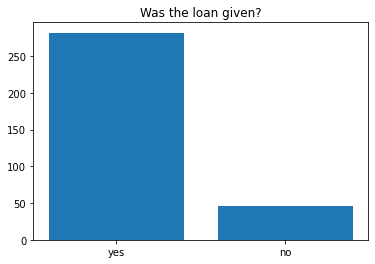

In [35]:
loan_status = loan_dev['status'].value_counts()
plt.title("Was the loan given?")
plt.bar(['yes', 'no'], list(loan_status))

In the box plot and histogram below we can see that the duration of the loans has a uniform distribution.

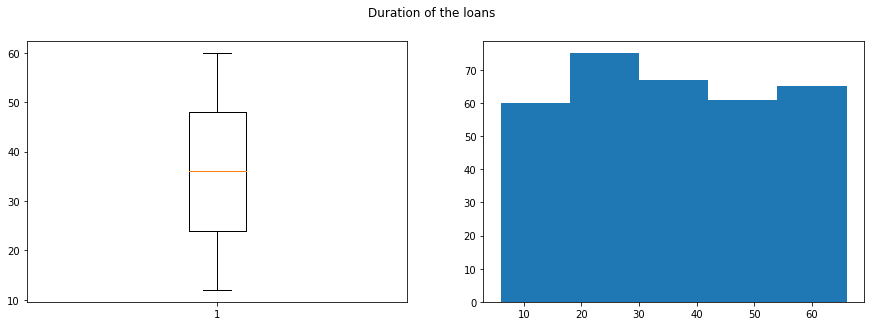

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 4.8)
fig.suptitle("Duration of the loans")

ax1.boxplot(loan_dev["duration"])
ax2.hist(loan_dev["duration"].values, [6, 18, 30, 42, 54, 66])
plt.show()

In the box plot and histogram below we can see that the amount of money requested for loans looks like a poisson distribution. The density of the data until the median is much greater than after it. Also, in the box plot, it's poossible to verify the existence of some outliers.

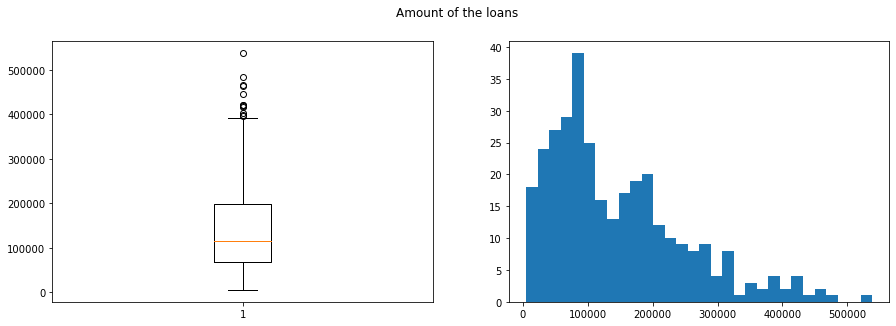

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 4.8)
fig.suptitle("Amount of the loans")

ax1.boxplot(loan_dev["amount"])
ax2.hist(loan_dev["amount"].values, 30)
plt.show()

By observation of the below scatter plots and histograms, we can conclude that the duration of the loan is not connected with the status of the loan since it have an uniform distribution. On the other hand, either the amount and the payments looks like they can be related since the percentage of negative status in higher payments and amounts is greater than it is in the lower ones.

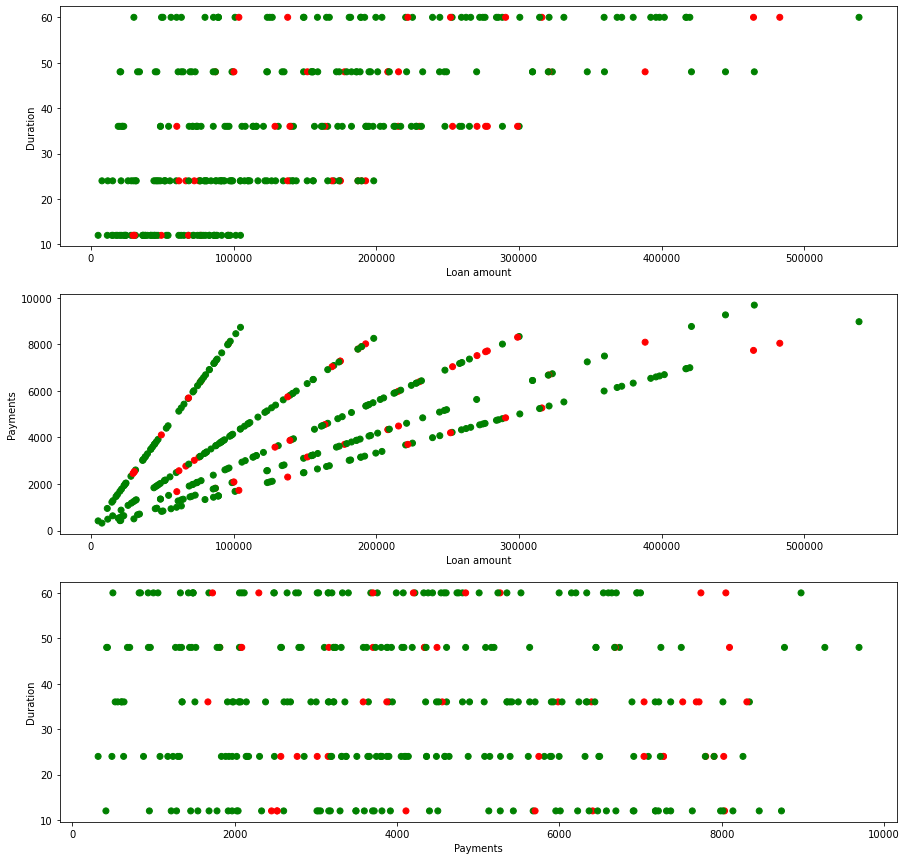

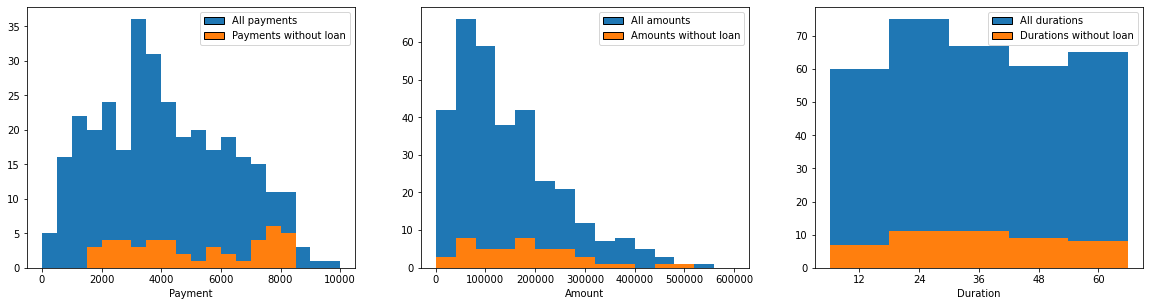

In [38]:
from matplotlib.patches import Rectangle


amount = loan_dev['amount']
duration = loan_dev['duration']
payments = loan_dev['payments']

colors = ['g' if s == 1 else 'r' for s in loan_dev['status']]

fig, (ax1, ax2,  ax3) = plt.subplots(3, figsize=[15, 15])
ax1.scatter(amount, duration, color=colors)
ax1.set_xlabel('Loan amount')
ax1.set_ylabel('Duration')
ax2.scatter(amount, payments, color=colors)
ax2.set_xlabel('Loan amount')
ax2.set_ylabel('Payments')
ax3.scatter(payments, duration, color=colors)
ax3.set_xlabel('Payments')
ax3.set_ylabel('Duration')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[20, 4.8])
handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in ['C0', 'C1']]

ax1.hist(payments, list(range(0, 10001, 500)), color='C0')
ax1.hist(loan_dev.query('status == -1')['payments'], list(range(0, 10001, 500)), color='C1')
ax1.set_xlabel('Payment')
ax1_labels = ["All payments", "Payments without loan"]
ax1.legend(handles, ax1_labels)

ax2.hist(amount, list(range(0, 600001, 40000)), color='C0')
ax2.hist(loan_dev.query('status == -1')['amount'], list(range(0, 600001, 40000)), color='C1')
ax2.set_xlabel('Amount')
ax2_labels = ["All amounts", "Amounts without loan"]
ax2.legend(handles, ax2_labels)

ax3.hist(duration, list(range(6, 70, 12)), color='C0')
ax3.hist(loan_dev.query('status == -1')['duration'], list(range(6, 70, 12)), color='C1')
ax3.set_xlabel('Duration')
ax3.set_xticks(list(range(12, 61, 12)))
ax3_labels = ["All durations", "Durations without loan"]
ax3.legend(handles, ax3_labels)
plt.show()

### Features conclusions

## Integrated Data Analysis

status
-1    2966.5
 1    4566.5
Name: monthly_diff, dtype: float64

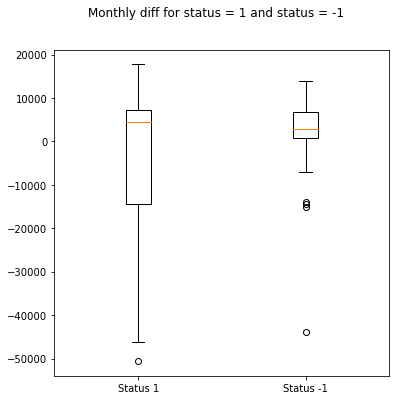

In [49]:
# Relation between status and monthly_diff

status_median_monthly_diff = data.groupby('status')['monthly_diff'].median()
display(status_median_monthly_diff)

aux = {'Status 1': data[data['status'] == 1]['monthly_diff'].values, 'Status -1': data[data['status'] == -1]['monthly_diff'].values}
fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle('Monthly diff for status = 1 and status = -1')
ax.boxplot(aux.values())
ax.set_xticklabels(aux.keys())
plt.show()


The plot below indicates that the gender of the client that requested the loan have no significant impact on the choice of loan or not.

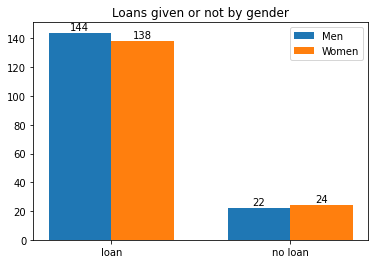

In [40]:
labels = ['loan', 'no loan']
aux = data.groupby('gender')['status'].value_counts()
female = aux[:2]
male = aux[2:]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, male, width, label='Men')
rects2 = ax.bar(x + width/2, female, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Loans given or not by gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=1)
ax.bar_label(rects2, padding=1)
plt.show()

### Correlation Map

/tmp/ipykernel_29310/4101906640.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


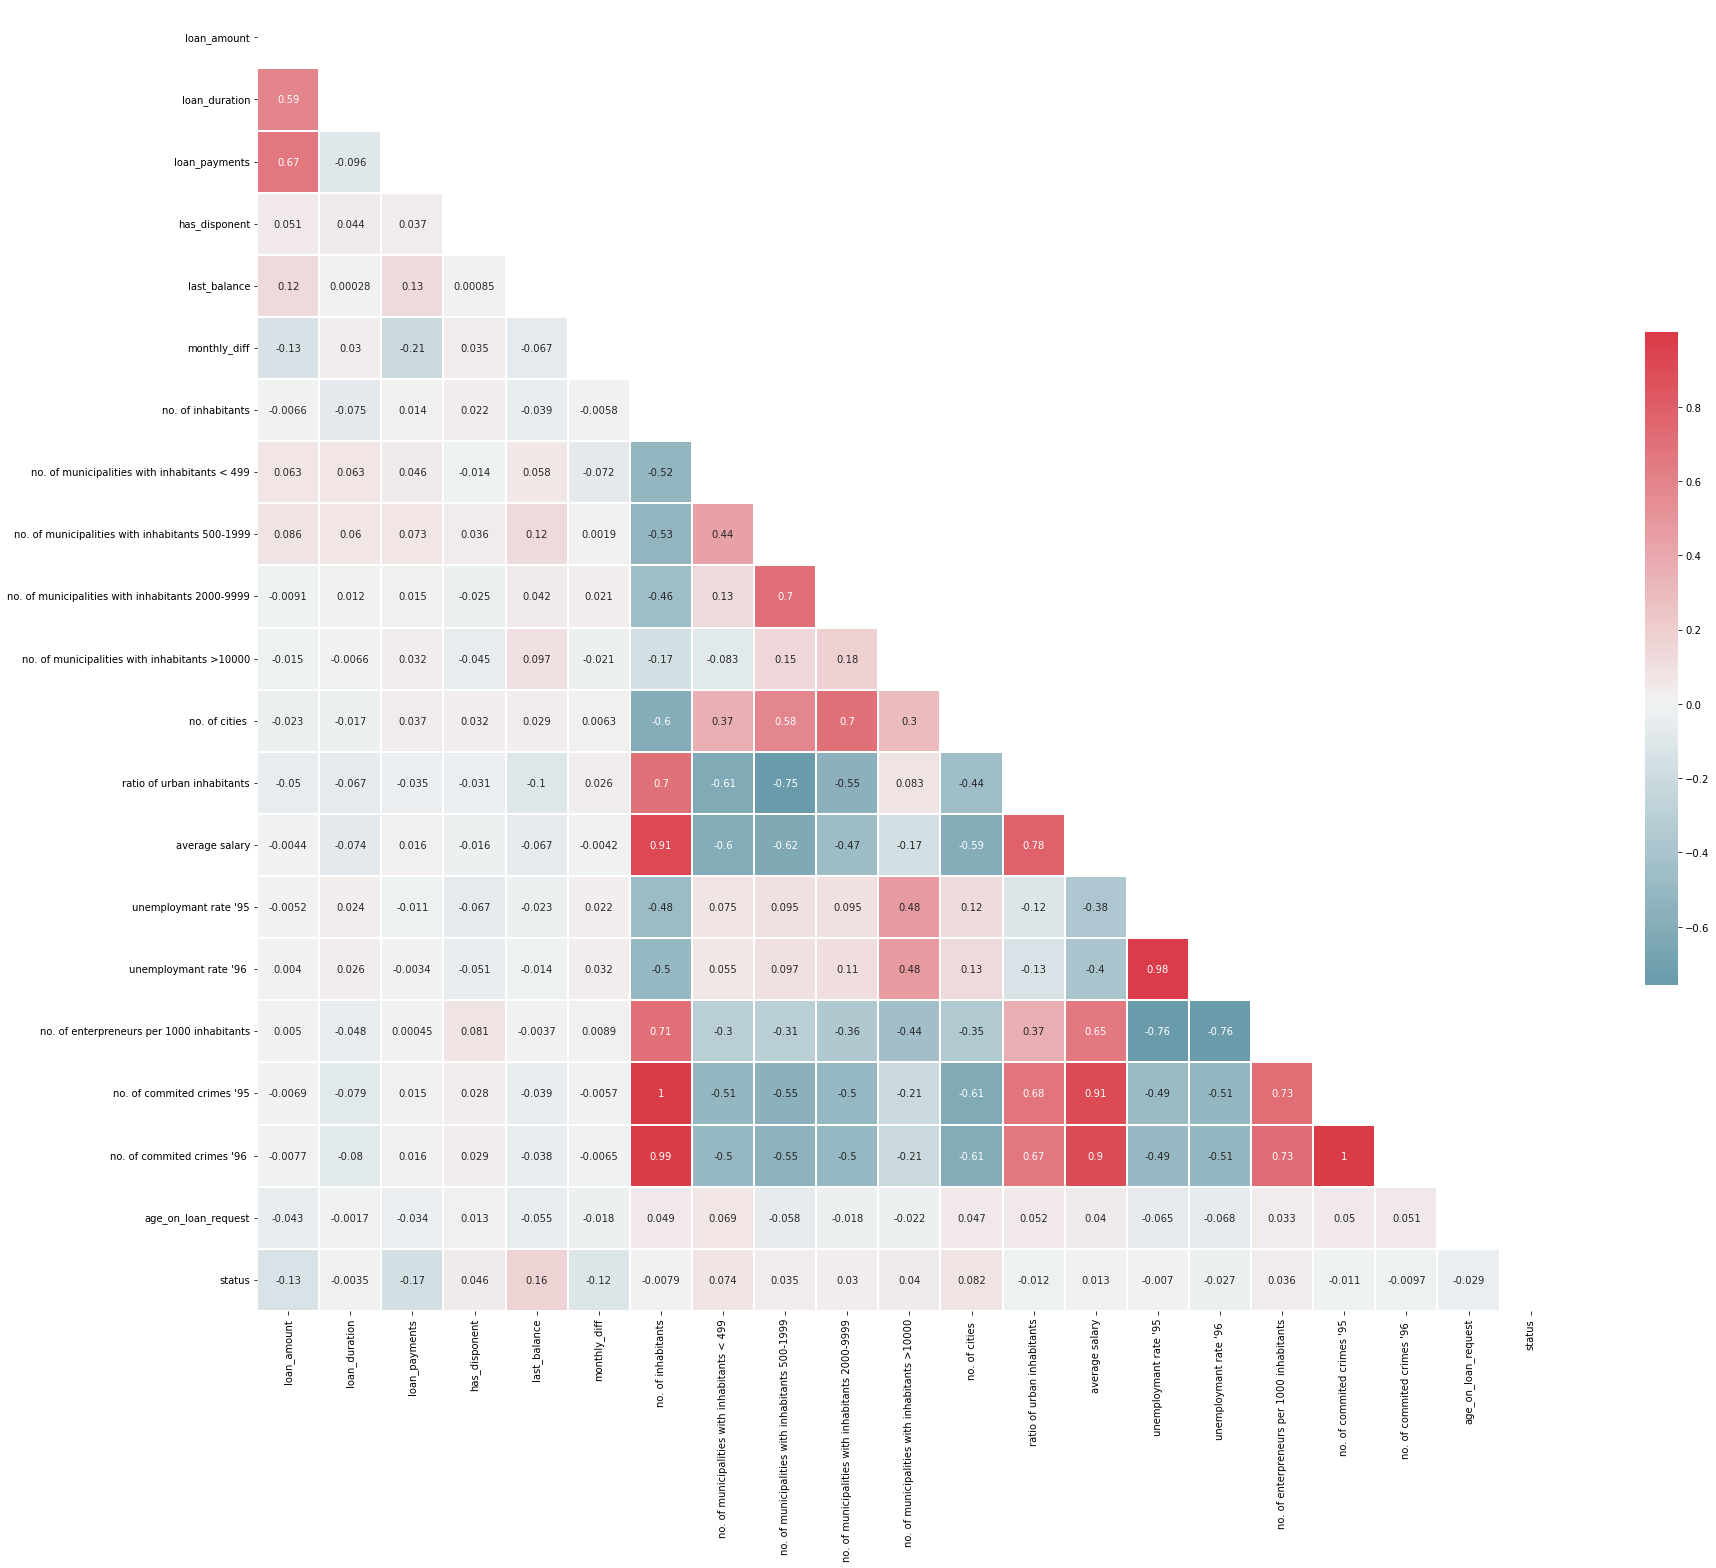

In [53]:
no_ids = [c for c in data.columns if c[-3:] != '_id' and c != 'code']
no_ids.remove('status')
no_ids.append('status')
get_correlation(data[no_ids])